# Feature Engineering

Creating the training and test sets for protoype experimentation.

In [1]:
import json
from pathlib import Path

import pandas as pd
from plotly.subplots import make_subplots

# Constants
TRAIN_FRAC = 0.8
SEED = 42
OUT_DIR = Path("../data/prototype")
OUT_DIR.mkdir(exist_ok=True)

# Data load
df = pd.read_csv(
    "../data/competition/train.csv",
    dtype={
        "id": pd.Int16Dtype(),
        "Time_spent_Alone": pd.Int8Dtype(),
        "Social_event_attendance": pd.Int8Dtype(),
        "Going_outside": pd.Int8Dtype(),
        "Friends_circle_size": pd.Int8Dtype(),
        "Post_frequency": pd.Int8Dtype(),
    },
)

## Drop Redundant Features

From the EDA, some features were found to be redundant or highly correlated to one another. 

In [2]:
df = df.drop(columns=["Drained_after_socializing", "Stage_fear"])

## Categorical to Numerical

Convert categorical values to numeric. This step defines the mappers used for each column.

In [3]:
mappers = {
    "Personality": {"Introvert": 0, "Extrovert": 1},
}

for col in mappers:
    df[col] = df[col].map(mappers[col]).astype(pd.Int8Dtype())

In [4]:
df.dtypes

id                         Int16
Time_spent_Alone            Int8
Social_event_attendance     Int8
Going_outside               Int8
Friends_circle_size         Int8
Post_frequency              Int8
Personality                 Int8
dtype: object

## Min-Max Normalization

All features have a well-known interval. Therefore, a simple normalization technique such as min-max can be applied both for training and inference:

- `Time_spent_Alone`: Hours spent alone daily (0–11).
- `Social_event_attendance`: Frequency of social events (0–10).
- `Going_outside`: Frequency of going outside (0–7).
- `Friends_circle_size`: Number of close friends (0–15).
- `Post_frequency`: Social media post frequency (0–10).

In [5]:
df["Time_spent_Alone"] = (df["Time_spent_Alone"] / 11).astype("float32")
df["Social_event_attendance"] = (df["Social_event_attendance"] / 11).astype("float32")
df["Going_outside"] = (df["Going_outside"] / 7).astype("float32")
df["Friends_circle_size"] = (df["Friends_circle_size"] / 15).astype("float32")
df["Post_frequency"] = (df["Post_frequency"] / 10).astype("float32")

In [6]:
df.dtypes

id                           Int16
Time_spent_Alone           float32
Social_event_attendance    float32
Going_outside              float32
Friends_circle_size        float32
Post_frequency             float32
Personality                   Int8
dtype: object

## Train and Validation sets

For the prototyping phase, we should have fixed datasets for training and another one for validation. Data should not leak between those datasets, from here onwards they should be treated independently.

In [7]:
train = df.sample(frac=TRAIN_FRAC, random_state=SEED)
validation = df[~df.id.isin(train.id)]

<Axes: >

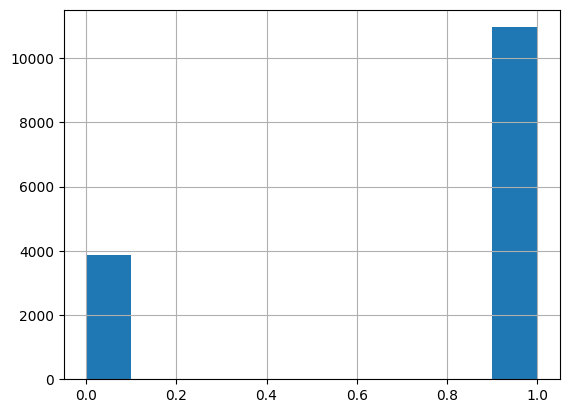

In [8]:
train["Personality"].hist()

<Axes: >

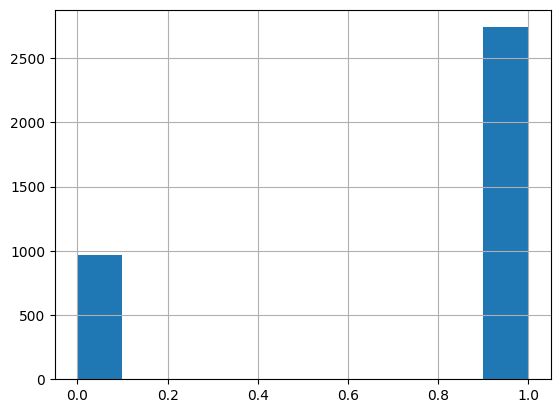

In [9]:
validation["Personality"].hist()

## Impute Missing Values on Train

Use a simple mean-strategy to impute missing values. We use the sample mean as a point estimator to the population mean. The validation set keeps NaN values to allow models to select a strategy to deal with it (i.e., either impute using the same mean as training or do something else).

In [10]:
train_statistics = train.describe()

In [11]:
for col in set(train.columns) - set(["id", "Personality"]):
    fill_value = train_statistics[col]["mean"]
    train[col] = train[col].fillna(value=fill_value)

In [12]:
assert not train.isna().any().any()

## Save Data

Save datasets and statistics.

In [13]:
with OUT_DIR.joinpath("mapper.json").open("w+") as f:
    json.dump(mappers, f, indent=2, ensure_ascii=False)

In [14]:
for fname, df in zip(
    ["train", "validation", "train_statistics"], [train, validation, train_statistics]
):
    df.to_parquet(
        OUT_DIR.joinpath(f"{fname}.parquet"), index=fname == "train_statistics"
    )